In [1]:
import pickle
from pathlib import Path
from tqdm.auto import tqdm, trange

from sklearn.neighbors import NearestNeighbors, KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_1samp, ttest_rel, chi2, mannwhitneyu, levene
import numpy as np, pandas as pd
from algo.module import pearson_corr_coef

from matplotlib import pyplot as plt
import seaborn as sns

import itertools
import h5py
import warnings
import re
import os


/opt/conda/envs/3Dgenome/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load input & metadata

In [2]:
path2dir = Path('/home/xinyuelu/HiCFormer/data/gage-seq-AD-new')
cell_type_num = 26
gene_num = 7598
region_length = 400
target_length = 240
feat_1d_list = ['ab', 'is-hw25', 'is-hw50', 'is-hw100', 'genebody-hw0']
hic_1d_all = []
for feat_name in tqdm(feat_1d_list):
    with open(path2dir / f'1d-score-celltypebulk-10kb-{feat_name}_1024_200_uint8-new.pkl', 'rb') as f:
        hic_1d_all.append(pickle.load(f).reshape(cell_type_num, gene_num, region_length).astype(float) / 255)
hic_1d_all = np.stack(hic_1d_all, axis=-1)
print('Hi-C 1D', hic_1d_all.shape)

with open(path2dir / 'expression_cov_1024_200_celltypebulk.pkl', 'rb') as f:
    expression_all = pickle.load(f)
expression_all = np.concatenate([_.toarray() for _ in expression_all.ravel()], axis=0).reshape(cell_type_num, gene_num, region_length)
expression_all = expression_all.reshape(cell_type_num, gene_num * region_length)
row_min = np.min(expression_all, axis=1, keepdims=True)
row_max = np.max(expression_all, axis=1, keepdims=True)
expression_all = (expression_all - row_min) / (row_max - row_min)
expression_all = np.log1p(expression_all * 1e4)
expression_all = expression_all.reshape(cell_type_num, gene_num, region_length)
print('expression', expression_all.shape)

with open(path2dir / 'sequence_1024_200.tsv', 'r') as f:
    sequence_all = np.array(f.read().upper().strip().split())
print('sequence', sequence_all.shape, len(sequence_all[0]))

df_meta_gene = pd.read_csv(path2dir / 'genes.tsv', sep='\t')
print('Gene meta data', df_meta_gene.shape)

df_meta_cell = pd.read_csv(path2dir / 'cells.tsv', sep='\t')
print('Cell meta data', df_meta_cell.shape)

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Hi-C 1D (26, 7598, 400, 5)
expression (26, 7598, 400)
sequence (7598,) 409600
Gene meta data (7598, 4)
Cell meta data (22395, 3)


In [10]:
with open(path2dir / 'cell_types.tsv', 'r') as f:
    cell_type_list = np.array(f.read().strip().split('\n'))
print(cell_type_list)
cell_type_list = [cell_type.replace("/", "") for cell_type in cell_type_list]

['Astro-AD' 'Astro-CT' 'Exc L2/3 IT-AD' 'Exc L2/3 IT-CT' 'Exc L4 IT-AD'
 'Exc L4 IT-CT' 'Exc L5 IT-AD' 'Exc L5 IT-CT' 'Exc L6b-AD' 'Exc L6b-CT'
 'Inh Lamp5-AD' 'Inh Lamp5-CT' 'Inh Pvalb-AD' 'Inh Pvalb-CT' 'Inh Sncg-AD'
 'Inh Sncg-CT' 'Inh Sst-AD' 'Inh Sst-CT' 'Inh Vip-AD' 'Inh Vip-CT'
 'Micro-AD' 'Micro-CT' 'OPC-AD' 'OPC-CT' 'Oligo-AD' 'Oligo-CT']


In [ ]:
all_genes = list(df_meta_gene['gene_id'])

## Read gene id conversion file

In [ ]:
df_gene_id_conversion = pd.read_csv(
    '/home/xinyuelu/HiCFormer/data/gage-seq-AD-new/gene_id_conversion.tsv',
    header=0, sep=',', index_col=0
)
df_gene_id_conversion.head()

## Load groundtruth and predicted expression data

In [ ]:
baseline_id = 'sh96uj2x'
hicformer_id = 'bxyu1uwc'                                                               

In [5]:
path2dir = Path('/home/xinyuelu/HiCFormer/data/gage-seq-AD-new')
with h5py.File(f'{path2dir}/contact_1024_200_celltypebulk.h5', 'r') as f:
    print(list(f.keys())[:10])
    print(list(f['Astro-AD'].keys())[:26])
    print(list(f['Astro-AD/ENSG00000000460'].keys())[:10])
    print(np.array(f['Astro-AD/ENSG00000000938/data']))

['Astro-AD', 'Astro-CT', 'Exc L23 IT-AD', 'Exc L23 IT-CT', 'Exc L4 IT-AD', 'Exc L4 IT-CT', 'Exc L5 IT-AD', 'Exc L5 IT-CT', 'Exc L6b-AD', 'Exc L6b-CT']
['ENSG00000000460', 'ENSG00000000938', 'ENSG00000001084', 'ENSG00000001167', 'ENSG00000001561', 'ENSG00000001617', 'ENSG00000001626', 'ENSG00000002549', 'ENSG00000002834', 'ENSG00000003056', 'ENSG00000003147', 'ENSG00000003393', 'ENSG00000003400', 'ENSG00000003402', 'ENSG00000003436', 'ENSG00000003509', 'ENSG00000003987', 'ENSG00000003989', 'ENSG00000004399', 'ENSG00000004468', 'ENSG00000004478', 'ENSG00000004487', 'ENSG00000004660', 'ENSG00000004700', 'ENSG00000004799', 'ENSG00000004809']
['col', 'data', 'row']
[0.5017361 3.0104167 0.5017361 ... 1.5052084 2.0069444 0.5017361]


In [12]:
with h5py.File(f'{path2dir}/expression_prediction_{hicformer_id}.h5', 'r') as f:
    for model_id in [
        hicformer_id
    ]:
        prediction_all = np.empty([cell_type_num, gene_num, target_length])
        for (gene_idx, gene_id), (cell_type_idx, cell_type_name) in tqdm(list(itertools.product(
            enumerate(df_meta_gene.gene_id),
            enumerate(cell_type_list),
        ))):
            prediction_all[cell_type_idx, gene_idx, :] = f[f'{gene_id}/{cell_type_name}/{model_id}']

  0%|          | 0/197548 [00:00<?, ?it/s]

100%|██████████| 197548/197548 [00:37<00:00, 5233.58it/s]


In [13]:
with open(path2dir / 'cell_types.tsv', 'r') as f:
    cell_type_list = np.array(f.read().strip().split('\n'))
cell_type_list = [cell_type.replace(" ", "_").replace("/", "_") for cell_type in cell_type_list]
with h5py.File(f'{path2dir}/expression_prediction_{baseline_id}.h5', 'r') as f:
    for model_id in [
        baseline_id
    ]:
        prediction_all_baseline = np.empty([cell_type_num, gene_num, target_length])
        for (gene_idx, gene_id), (cell_type_idx, cell_type_name) in tqdm(list(itertools.product(
            enumerate(df_meta_gene.gene_id),
            enumerate(cell_type_list),
        ))):
            prediction_all_baseline[cell_type_idx, gene_idx, :] = f[f'{gene_id}/{cell_type_name}/{model_id}']

  0%|          | 913/197548 [00:00<00:42, 4641.97it/s]

100%|██████████| 197548/197548 [00:37<00:00, 5335.37it/s]


In [14]:
prediction_all.shape, prediction_all_baseline.shape

((26, 7598, 240), (26, 7598, 240))

## Load gene annotation

In [ ]:
def load_gene_annotation(filename=None, version=None, keep_type=('gene',)):
	if filename is None:
		if version == 'hg38':
			fmt = 'gtf'
			filename = '/home/xinyuelu/genome/hg38/gencode.v47.annotation.gtf'
		else:
			raise NotImplementedError()
	else:
		raise NotImplementedError()
	df = pd.read_csv(
		filename,
		header=0,
		skiprows=7 if fmt == 'gff3' else 5,
		usecols=[0, 2, 3, 4, 6, 8],
		index_col=False,
		names=['chrom', 'type', 'start', 'end', 'strand', 'annotation'],
		delimiter='\t',
	)
	if keep_type is not None:
		df = df[df['type'].isin(keep_type)]
	if fmt == 'gff3':
		pattern = re.compile(r'gene_name=([^;]+);')
		df['gene_name'] = [pattern.search(_).group(1) for _ in df['annotation']]
		pattern = re.compile(r'gene_type=([^;]+);')
		df['gene_type'] = [pattern.search(_).group(1) for _ in df['annotation']]
		pattern = re.compile(r'ID=([^;]+)\.\d+;')
		df['ID'] = [pattern.search(_).group(1) for _ in df['annotation']]
		pattern = re.compile(r'gene_id=([^;]+)\.\d+;')
		df['gene_id'] = [pattern.search(_).group(1) for _ in df['annotation']]
	else:
		pattern = re.compile(r'gene_name "([^"]+)";')
		df['gene_name'] = [pattern.search(_).group(1) for _ in df['annotation']]
		pattern = re.compile(r'gene_type "([^;]+)";')
		df['gene_type'] = [pattern.search(_).group(1) for _ in df['annotation']]
		# pattern = re.compile(r'gene_id "([^"]+)\.\d+";')
		pattern = re.compile(r'gene_id "([^"]+)";')
		df['ID'] = [pattern.search(_).group(1).split('.')[0] for _ in df['annotation']]
		# pattern = re.compile(r'gene_id "([^"]+)";')
		# df['gene_id'] = [pattern.search(_).group(1) for _ in df['annotation']]
		df['gene_id'] = df['ID']
	return df

In [17]:
df_gene_anno = load_gene_annotation(version='hg38')

In [18]:
df_gene_anno.head()

,chrom,type,start,end,strand,annotation,gene_name,gene_type,ID,gene_id
123,chr1,gene,12010,13670,+,"gene_id ""ENSG00000223972.6""; gene_type ""transc...",DDX11L1,transcribed_unprocessed_pseudogene,ENSG00000223972,ENSG00000223972
131,chr1,gene,14356,30744,-,"gene_id ""ENSG00000310526.1""; gene_type ""lncRNA...",WASH7P,lncRNA,ENSG00000310526,ENSG00000310526
2402,chr1,gene,14696,24886,-,"gene_id ""ENSG00000227232.6""; gene_type ""transc...",WASH7P,transcribed_unprocessed_pseudogene,ENSG00000227232,ENSG00000227232
2414,chr1,gene,17369,17436,-,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""...",MIR6859-1,miRNA,ENSG00000278267,ENSG00000278267
2417,chr1,gene,28589,31109,+,"gene_id ""ENSG00000243485.6""; gene_type ""lncRNA...",MIR1302-2HG,lncRNA,ENSG00000243485,ENSG00000243485


In [19]:
# gene symbol:ensembl id mapping dict
mapping_dict = df_gene_anno.set_index('gene_name')['gene_id'].to_dict()
mapping_dict_rev = df_gene_anno.set_index('gene_id')['gene_name'].to_dict()

In [20]:
prediction_all.shape, expression_all.shape

((26, 7598, 240), (26, 7598, 400))

## Initial performance evaluation

In [21]:
def calc_metric(prediction_all, cell_type_idx, gene_idx):
    pred = prediction_all[cell_type_idx][:, gene_idx, :]
    truth = expression_all[cell_type_idx][:, gene_idx, 80:-80]
    print(pearsonr(pred.ravel(), truth.ravel()))

In [22]:
seen_cell_type_idx = [2,3,4,5,6,7,8,9,11,13,14,15,16,18,19,20,22,23,24,25]
unseen_cell_type_idx = [0,1,10,12,17,21]
seen_gene_idx = np.arange(int(gene_num*0.8))
unseen_gene_idx = np.arange(int(gene_num*0.8), gene_num)

In [23]:
ad_cell_type_idx = [2 * i for i in range(13)]
ct_cell_type_idx = [2 * i + 1 for i in range(13)]

In [27]:
all_cell_type_idx = np.arange(26)
all_gene_idx = np.array(list(seen_gene_idx) + list(unseen_gene_idx))
# calc_metric(prediction_all, all_cell_type_idx, all_gene_idx)
# calc_metric(prediction_all_baseline, all_cell_type_idx, all_gene_idx)

In [ ]:
calc_metric(prediction_all, ad_cell_type_idx, all_gene_idx)
calc_metric(prediction_all_baseline, ad_cell_type_idx, all_gene_idx)

PearsonRResult(statistic=0.7506668997503841, pvalue=0.0)


PearsonRResult(statistic=0.6710506404224839, pvalue=0.0)


In [ ]:
calc_metric(prediction_all, ct_cell_type_idx, all_gene_idx)
calc_metric(prediction_all_baseline, ct_cell_type_idx, all_gene_idx)

PearsonRResult(statistic=0.7809445596225664, pvalue=0.0)
PearsonRResult(statistic=0.7168287750657711, pvalue=0.0)


In [31]:
calc_metric(prediction_all_baseline, seen_cell_type_idx, seen_gene_idx)
calc_metric(prediction_all_baseline, unseen_cell_type_idx, seen_gene_idx)
calc_metric(prediction_all_baseline, seen_cell_type_idx, unseen_gene_idx)
calc_metric(prediction_all_baseline, unseen_cell_type_idx, unseen_gene_idx)

PearsonRResult(statistic=0.7449522491530635, pvalue=0.0)
PearsonRResult(statistic=0.6806515184577652, pvalue=0.0)
PearsonRResult(statistic=0.5441862962857257, pvalue=0.0)
PearsonRResult(statistic=0.5304036670952654, pvalue=0.0)


In [32]:
calc_metric(prediction_all, seen_cell_type_idx, seen_gene_idx)
calc_metric(prediction_all, unseen_cell_type_idx, seen_gene_idx)
calc_metric(prediction_all, seen_cell_type_idx, unseen_gene_idx)
calc_metric(prediction_all, unseen_cell_type_idx, unseen_gene_idx)

PearsonRResult(statistic=0.8152954493002902, pvalue=0.0)
PearsonRResult(statistic=0.7693713651781175, pvalue=0.0)
PearsonRResult(statistic=0.6028694920294925, pvalue=0.0)
PearsonRResult(statistic=0.6157779480218124, pvalue=0.0)


## Get train/validation/test expression

In [33]:
def fn_expr(expr):
    return expr[seen_cell_type_idx][:, seen_gene_idx, :], \
           expr[seen_cell_type_idx][:, unseen_gene_idx, :], \
           expr[unseen_cell_type_idx][:, seen_gene_idx, :], \
           expr[unseen_cell_type_idx][:, unseen_gene_idx, :],

In [34]:
pred_train, pred_valid1, pred_valid2, pred_test = fn_expr(prediction_all)
pred_train_baseline, pred_valid1_baseline, pred_valid2_baseline, pred_test_baseline = fn_expr(prediction_all_baseline)
expr_train, expr_valid1, expr_valid2, expr_test = fn_expr(expression_all[:,:,80:-80])

In [35]:
prediction_all.shape, prediction_all_baseline.shape, expression_all.shape

((26, 7598, 240), (26, 7598, 240), (26, 7598, 400))

In [36]:
cell_type_num = 26
gene_num = 7598
train_cell_type_num = 20
test_cell_type_num = 6
train_gene_num = int(gene_num * 0.8)
test_gene_num = gene_num - train_gene_num

In [37]:
def fn_test(x):
    return x.transpose(1, 0, 2).reshape(test_gene_num, test_cell_type_num * 240)
def fn_valid1(x):
    return x.transpose(1, 0, 2).reshape(test_gene_num, train_cell_type_num * 240)
def fn_valid2(x):
    return x.transpose(1, 0, 2).reshape(train_gene_num, test_cell_type_num * 240)
def fn_train(x):
    return x.transpose(1, 0, 2).reshape(train_gene_num, train_cell_type_num * 240)
def fn_all(x):
    return x.transpose(1, 0, 2).reshape(gene_num, (train_cell_type_num + test_cell_type_num) * 240)

In [38]:
corr = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_all(prediction_all), fn_all(expression_all[:,:,80:-80])))])
corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_all(prediction_all_baseline), fn_all(expression_all[:,:,80:-80])))])

7598it [00:07, 1034.15it/s]
7598it [00:07, 1035.52it/s]


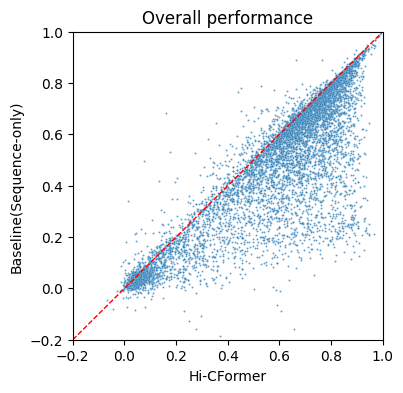

In [39]:
x = corr
y = corr_baseline
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(ax=ax, x=x, y=y, s=2, alpha=0.7)
ax.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1)
ax.set(xlabel=f'Hi-CFormer', ylabel=f'Baseline(Sequence-only)')
ax.set_title("Overall performance")
ax.set_xlim((-0.2, 1))
ax.set_ylim((-0.2, 1))
plt.show()
plt.close('all')

In [ ]:
degresdir = "/home/xinyuelu/AD-proj/results/results-annotate-hPFC/DEG_hPFC-lib-all/all/sub_cell_type"
filtered_celltypes = ['Exc L2/3 IT','Exc L4 IT','Exc L5 IT','Exc L6b',
                      'Inh Lamp5','Inh Pvalb','Inh Vip','Inh Sst','Inh Sncg',
                      'Oligo','Astro','Micro','OPC']

def get_selected_degs(filtered_celltypes, degresdir, mapping_dict):
    deg_list_up = []
    deg_list_down = []

    for c in filtered_celltypes:
        # c = re.sub(r"/", "-", c)
        df = pd.read_csv(f"{degresdir}/{c}-AD-vs-CT-MAST.csv")
        df = df.rename(columns={df.columns[0]: 'gene_name'})
        df = df[df['p_val_adj'] <= 0.05]
        df_up = df[df['avg_log2FC'] >= 0.25]
        df_down = df[df['avg_log2FC'] <= -0.25]
        # df = df[(df['pct.1'] >= 0.1) | (df['pct.2'] >= 0.1)]
        deg_list_up.extend(list(df_up['gene_name']))
        deg_list_down.extend(list(df_down['gene_name']))

    deg_list_up = list(set(deg_list_up))
    deg_list_down = list(set(deg_list_down))

    selected_degs_name_up = []
    selected_degs_name_down = []
    for g in deg_list_up:
        if g in mapping_dict:
            selected_degs_name_up.append(mapping_dict[g])
    for g in deg_list_down:
        if g in mapping_dict:
            selected_degs_name_down.append(mapping_dict[g])

    return deg_list_up, selected_degs_name_up, deg_list_down, selected_degs_name_down


## Gene set performance

In [44]:
neg_gene_set = pd.read_csv("gene_set_vs_mingling_negative_cor.tsv", sep = '\t')
neg_gene_set.head()
all_neg_gene_set = []
all_neg_gene_set_name = []
for i, df in neg_gene_set.groupby('gene_set'):
    tmp = list(df['gene_name'])
    mod = []
    for g in tmp:
        if g not in mapping_dict:
            continue
        id = mapping_dict[g]
        if id not in all_genes:
            continue
        mod.append(all_genes.index(id)) 
    
    all_neg_gene_set.append(mod)
    all_neg_gene_set_name.append(i)

In [45]:
pos_gene_set = pd.read_csv("gene_set_vs_mingling_positive_cor.tsv", sep = '\t')
pos_gene_set.head()
all_pos_gene_set = []
all_pos_gene_set_name = []
for i, df in pos_gene_set.groupby('gene_set'):
    tmp = list(df['gene_name'])
    mod = []
    for g in tmp:
        if g not in mapping_dict:
            continue
        id = mapping_dict[g]
        if id not in all_genes:
            continue
        mod.append(all_genes.index(id)) 
    
    all_pos_gene_set.append(mod)
    all_pos_gene_set_name.append(i)

In [54]:
f_pos_gene_set, f_pos_gene_set_name = zip(*[
    (gene_set, name)
    for gene_set, name in zip(all_pos_gene_set, all_pos_gene_set_name)
    if len(gene_set) > 10
])

In [57]:
f_neg_gene_set, f_neg_gene_set_name = zip(*[
    (gene_set, name)
    for gene_set, name in zip(all_neg_gene_set, all_neg_gene_set_name)
    if len(gene_set) > 10
])

In [58]:
corr_diff = [corr[i] - corr_baseline[i] for i in range(len(corr))]

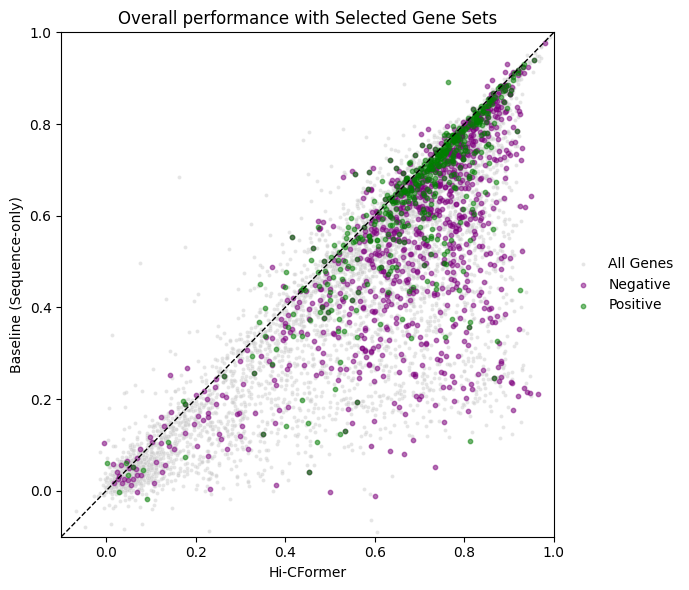

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(x=x, y=y, s=8, alpha=0.5, ax=ax, color='#CCCCCC', label="All Genes")


all_neg = list(set([i for gene_set in f_neg_gene_set for i in gene_set]))
ax.scatter(x[all_neg], y[all_neg], color='purple', s=10, alpha=0.5, label = 'Negative')

all_pos = list(set([i for gene_set in f_pos_gene_set for i in gene_set]))
ax.scatter(x[all_pos], y[all_pos], color='green', s=10, alpha=0.5, label = 'Positive')

ax.axline((0, 0), slope=1, color='black', linestyle='--', linewidth=1)

ax.set_xlabel('Hi-CFormer')
ax.set_ylabel('Baseline (Sequence-only)')
ax.set_title('Overall performance with Selected Gene Sets')
ax.set_xlim(-0.1, 1)
ax.set_ylim(-0.1, 1)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5), 
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.savefig('all_corr_genes_performance.pdf',dpi=500)
plt.show()



## Train / Validation / Test dataset performance

In [40]:
train_corr = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_train(pred_train), fn_train(expr_train)))])
train_corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_train(pred_train_baseline), fn_train(expr_train)))])

6078it [00:06, 956.75it/s]
6078it [00:06, 960.30it/s]


In [41]:
test_corr = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_test(pred_test), fn_test(expr_test)))])
test_corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_test(pred_test_baseline), fn_test(expr_test)))])

1520it [00:01, 998.07it/s] 
1520it [00:01, 984.46it/s]


In [42]:
valid_corr_1 = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_valid1(pred_valid1), fn_valid1(expr_valid1)))])
valid_corr_1_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_valid1(pred_valid1_baseline), fn_valid1(expr_valid1)))])

1520it [00:01, 978.78it/s]
1520it [00:01, 924.04it/s]


In [43]:
valid_corr_2 = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_valid2(pred_valid2), fn_valid2(expr_valid2)))])
valid_corr_2_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_valid2(pred_valid2_baseline), fn_valid2(expr_valid2)))])

6078it [00:06, 998.46it/s] 
6078it [00:06, 997.82it/s] 


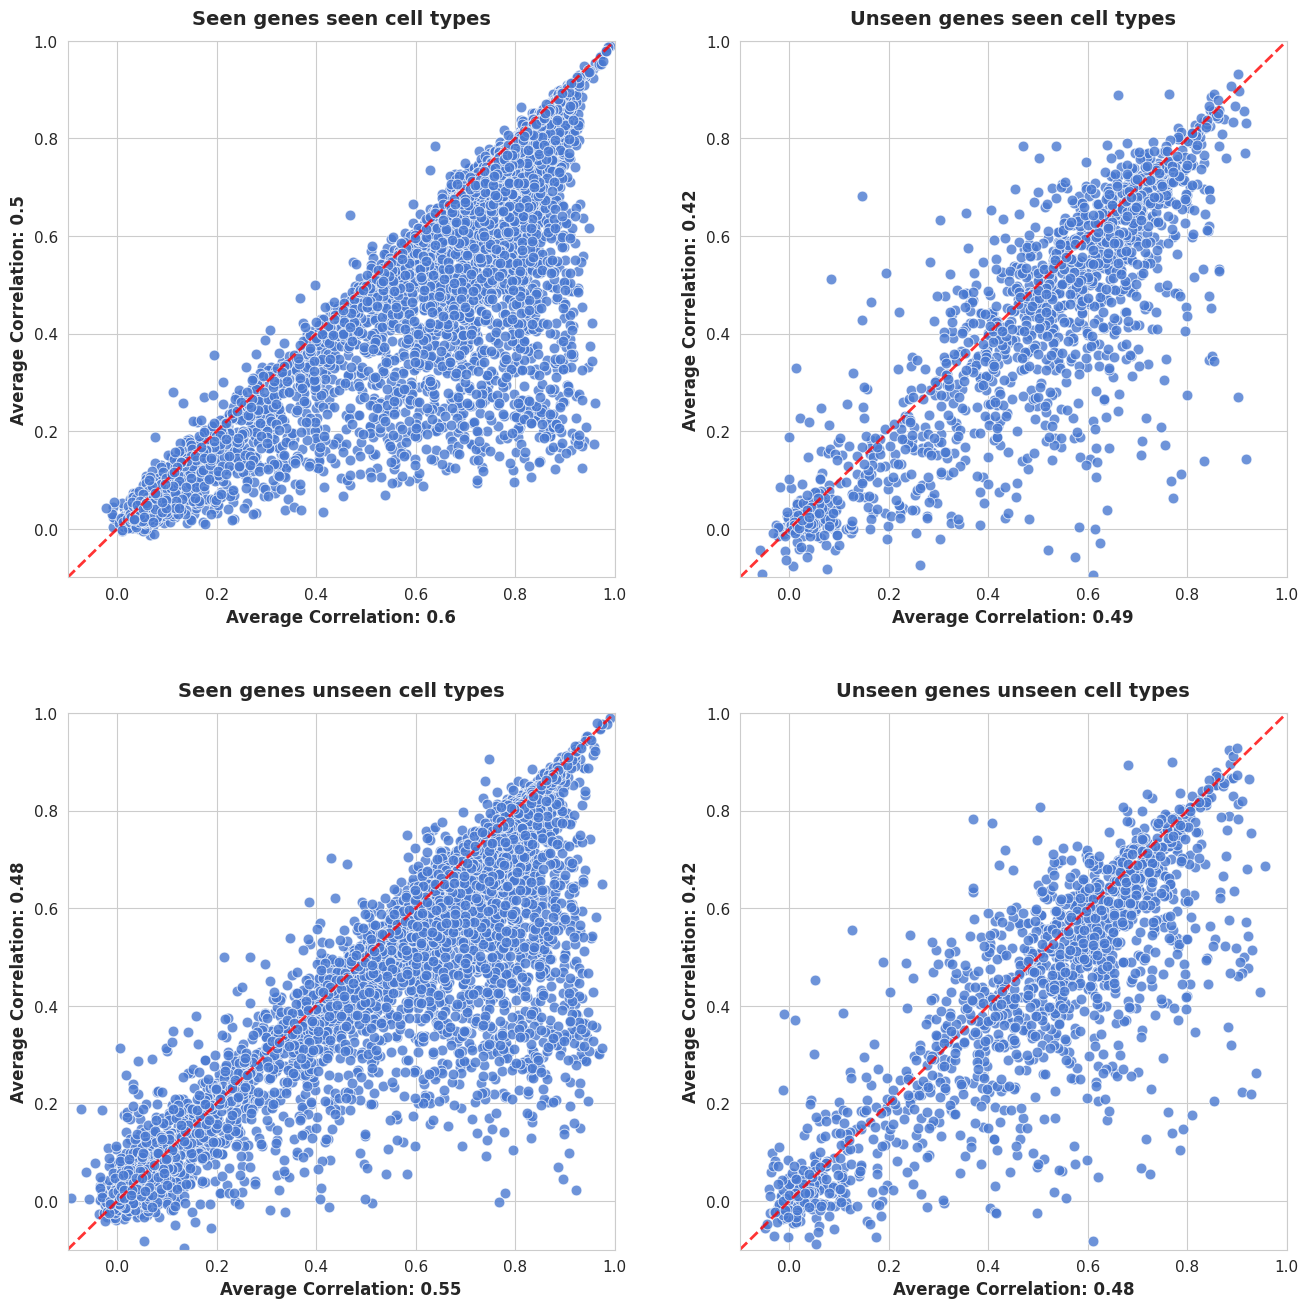

In [ ]:
def per_gene_performance_scatterplots(data, titles, xlabel, ylabel):
    sns.set_style("whitegrid")
    sns.set_palette("muted")
    
    limits = (-0.1, 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()  

    for i, (x, y) in enumerate(data):
        ax = axes[i]
        sns.scatterplot(ax=ax, x=x, y=y, s=60, alpha=0.8)

        ax.plot([limits[0], limits[1]], [limits[0], limits[1]], color='red', linestyle='--', linewidth=2, alpha=0.8)

        ax.set_xlabel(f'Average Correlation: {np.round(np.mean(x),2)}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Average Correlation: {np.round(np.mean(y),2)}', fontsize=12, fontweight='bold')
        ax.set_title(titles[i], fontsize=14, fontweight='bold', pad=12)
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.tick_params(axis='both', labelsize=11)

    plt.tight_layout(pad=4)
    plt.savefig("gene_level_eval.pdf",dpi=500)
    plt.show()


data = [
    (train_corr, train_corr_baseline),
    (valid_corr_1, valid_corr_1_baseline),
    (valid_corr_2, valid_corr_2_baseline),
    (test_corr, test_corr_baseline),
]
titles = [
    "Seen genes seen cell types",
    "Unseen genes seen cell types",
    "Seen genes unseen cell types",
    "Unseen genes unseen cell types",
]

per_gene_performance_scatterplots(data, titles, "Hi-CFormer", "Baseline (Sequence-only)")

## Per cell type evaluation

In [30]:
prediction_all.shape, prediction_all_baseline.shape, expression_all.shape

((26, 7598, 240), (26, 7598, 240), (26, 7598, 400))

In [31]:
def normalize(x):
    c, g, l = x.shape
    return StandardScaler().fit_transform(x.transpose(0, 2, 1).reshape(c*l, g))\
        .reshape(c, l, g).transpose(0, 2, 1)
def calc_metric(x, y, metric_str):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    if metric_str == 'pearson':
        return np.array([pearsonr(x[i, :], y[i, :])[0] for i in range(x.shape[0])])
        # return (x * y).mean(-1)
    elif metric_str == 'mse':
        return np.linalg.norm(x-y, axis=-1, ord=2) / np.sqrt(x.shape[-1])
    else:
        raise NotImplementedError

In [32]:
exc_idx = [2,3,4,5,6,7,8,9]
inh_idx = [10,11,12,13,14,15,16,17,18,19]
astro_idx = [0,1]
micro_idx = [20,21]
opc_idx = [22,23]
oligo_idx = [24,25]

In [33]:
exc_idx_ad = [2,4,6,8]
exc_idx_ct = [3,5,7,9]
inh_idx_ad = [10,12,14,16,18]
inh_idx_ct = [11,13,15,17,19]
astro_idx_ad = [0]
astro_idx_ct = [1]
micro_idx_ad = [20]
micro_idx_ct = [21]
opc_idx_ad = [22]
opc_idx_ct = [23]
oligo_idx_ad = [24]
oligo_idx_ct = [25]

In [39]:
all_idx = [exc_idx_ad, exc_idx_ct, inh_idx_ad, inh_idx_ct, astro_idx_ad, astro_idx_ct, oligo_idx_ad, oligo_idx_ct, micro_idx_ad, micro_idx_ct, opc_idx_ad, opc_idx_ct]
all_cell_types = ['Exc-AD', 'Exc-CT', 'Inh-AD', 'Inh-CT', 'Astro-AD', 'Astro-CT', 'Oligo-AD', 'Oligo-CT', 'Micro-AD', 'Micro-CT', 'OPC-AD', 'OPC-CT']

In [36]:
def get_performance_df(cell_type_indices, gene_indices):
    def calc_metric(x, y):
        c, g, l = x.shape
        x = x.transpose(1, 0, 2).reshape(g, c*l)
        y = y.transpose(1, 0, 2).reshape(g, c*l)
        #return np.linalg.norm(x-y, axis=-1, ord=2) / np.sqrt(x.shape[-1])
        return np.array([pearsonr(*_)[0] for _ in zip(x, y)])
    p_h = prediction_all[cell_type_indices][:, gene_indices]
    p_b = prediction_all_baseline[cell_type_indices][:, gene_indices]
    e = expression_all[cell_type_indices][:, gene_indices][..., 80:-80]
    df = pd.DataFrame({
        'Hi-CFormer': calc_metric(p_h, e),
        'Baseline': calc_metric(p_b, e),
        'gene_id': df_meta_gene.gene_id[gene_indices].values,
    }).set_index('gene_id')
    
    return df

In [ ]:
df_all_seen_genes = {}
for i in range(len(all_cell_types)):
    print(all_cell_types[i])
    df = get_performance_df(all_idx[i], seen_gene_idx)
    df_all_seen_genes[all_cell_types[i]] = df

Exc-AD


Exc-CT
Inh-AD
Inh-CT
Astro-AD
Astro-CT
Oligo-AD
Oligo-CT
Micro-AD
Micro-CT
OPC-AD
OPC-CT


/var/tmp/ipykernel_5290/1452996782.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return np.array([pearsonr(*_)[0] for _ in zip(x, y)])


In [83]:
df_meta_gene['gene_name'] = df_meta_gene.gene_id.apply(mapping_dict_rev.get)
df_meta_gene.head()

,gene_id,chrom,pos,strand,gene_name
0,ENSG00000067606,hg38_chr1,2050411,+,PRKCZ
1,ENSG00000157933,hg38_chr1,2227388,+,SKI
2,ENSG00000157916,hg38_chr1,2391775,+,RER1
3,ENSG00000157911,hg38_chr1,2413797,-,PEX10
4,ENSG00000157881,hg38_chr1,2526597,-,PANK4


### Get DEG performance

In [ ]:
path2dir = Path('/home/xinyuelu/AD-proj/results/results-annotate-hPFC/DEG_hPFC-lib-all/all/major_cell_type')
df_deg_dict = dict()
mapping = dict(__[::-1] for _, __ in df_gene_id_conversion.drop_duplicates('gene_name', keep=False).iterrows())
for filename in tqdm(os.listdir(path2dir)):
    df = pd.read_csv(path2dir / filename).rename(columns={'Unnamed: 0': 'gene_name'})
    df['gene_id'] = df.gene_name.apply(mapping.get)
    df = df.dropna()
    df_deg_dict[filename.split('-')[0]] = df

100%|██████████| 8/8 [00:00<00:00, 94.68it/s]


In [ ]:
all_cell_types = ['Exc', 'Inh', 'Glial']
exc_ct_list = ['Exc L2/3 IT','Exc L4 IT','Exc L5 IT','Exc L6b']
exc_deg_list, exc_deg_id = get_selected_degs(exc_ct_list, degresdir, mapping_dict)
inh_ct_list = ['Inh Lamp5','Inh Pvalb','Inh Vip','Inh Sst','Inh Sncg']
inh_deg_list, inh_deg_id = get_selected_degs(inh_ct_list, degresdir, mapping_dict)
glial_ct_list = ['Oligo','Micro','OPC','Astro']
glial_deg_list, glial_deg_id = get_selected_degs(glial_ct_list, degresdir, mapping_dict)

performance_explanation_box_deg.pdf


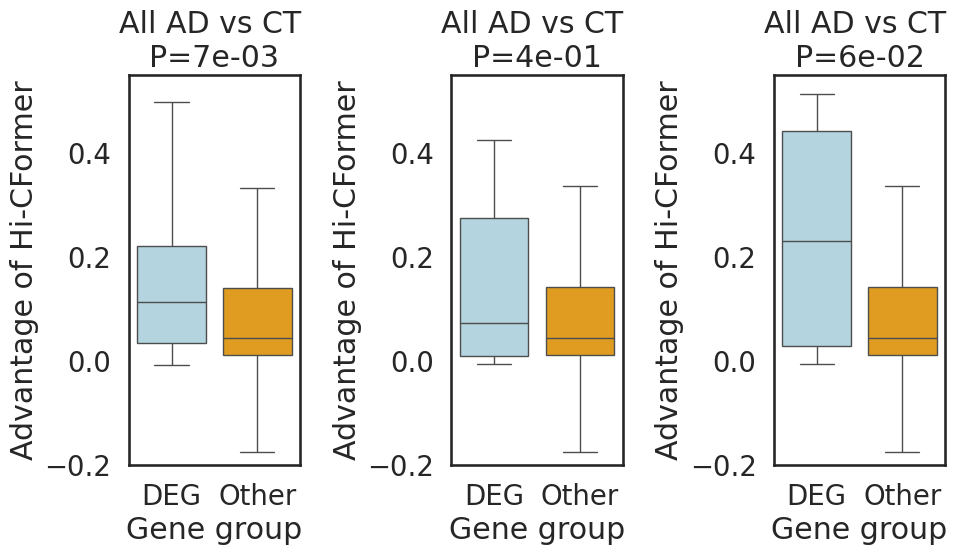

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,6))
all_degs = [exc_deg_id, inh_deg_id, glial_deg_id]
for ax, deg_key in zip(axes.flat, all_degs):
            
    df = pd.DataFrame(df_all_seen_genes['All']).copy()
    df['gene_id'] = df.index
    y = 'Advantage of Hi-CFormer'
    df[y] = df['Hi-CFormer'] - df['Baseline']
    df = df.dropna()
    df['group'] = np.where(
        df.gene_id.isin(deg_key),
        'DEG',
        'Other',
    )
    df.group = pd.Categorical(df.group, categories=np.unique(df.group))
    df['Gene group'] = df.group
    mask = df.group.eq('Other')
    stat, pval = ttest_ind(df.loc[~mask, y], df.loc[mask, y])
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        sns.boxplot(ax=ax, data=df, x='Gene group', y=y, showfliers=False, palette={"DEG": "lightblue", "Other": "orange"} )
    ax.set_title(f'All AD vs CT \nP={pval:.0e}')
    ax.set_ylim(-0.2, 0.55)
    # ax.tick_params('x', rotation=45)

fig.tight_layout()
path2file =  f'performance_explanation_box_deg.pdf'
print(path2file)
plt.savefig(path2file, dpi=600)
plt.show()
plt.close('all')

### Get per cell type performance (MSE)

In [ ]:
#metric_str = 'pearson'
metric_str = 'mse'
all_cell_type_idx = [i for i in range(26)]
all_gene_idx = [i for i in range(7598)]
cell_type_indices, gene_indices = all_cell_type_idx, all_gene_idx
def normalize(x):
    c, g, l = x.shape
    return StandardScaler().fit_transform(x.transpose(0, 2, 1).reshape(c*l, g))\
        .reshape(c, l, g).transpose(0, 2, 1)
def calc_metric(x, y):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    if metric_str == 'pearson':
        return np.array([pearsonr(x[i, :], y[i, :])[0] for i in range(x.shape[0])])
        # return (x * y).mean(-1)
    elif metric_str == 'mse':
        return np.linalg.norm(x-y, axis=-1, ord=2) / np.sqrt(x.shape[-1])
    else:
        raise NotImplementedError
p_h = normalize(prediction_all[cell_type_indices][:, gene_indices, :])
p_b = normalize(prediction_all_baseline[cell_type_indices][:, gene_indices, :])
e = normalize(expression_all[cell_type_indices][:, gene_indices, 80:-80])
cell_type_dict = {
    'Exc-AD': np.isin(
        np.array(cell_type_list)[cell_type_indices],
        [c for c in np.array(cell_type_list)[cell_type_indices] if c.startswith('Exc') and c.endswith('AD')]),
    'Inh-AD': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         [c for c in np.array(cell_type_list)[cell_type_indices] if c.startswith('Inh') and c.endswith('AD')]),
    'Oligo-AD': np.isin(
        np.array(cell_type_list)[cell_type_indices],
        ['Oligo-AD']),
    'Micro-AD': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         ['Micro-AD']),
    'Astro-AD': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         ['Astro-AD']),
    'OPC-AD': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         ['OPC-AD']),
    'Exc-CT': np.isin(
        np.array(cell_type_list)[cell_type_indices],
        [c for c in np.array(cell_type_list)[cell_type_indices] if c.startswith('Exc') and c.endswith('CT')]),
     'Inh-CT': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         [c for c in np.array(cell_type_list)[cell_type_indices] if c.startswith('Inh') and c.endswith('CT')]),
    'Oligo-CT': np.isin(
        np.array(cell_type_list)[cell_type_indices],
        ['Oligo-CT']),
     'Micro-CT': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         ['Micro-CT']),
     'Astro-CT': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         ['Astro-CT']),
     'OPC-CT': np.isin(
         np.array(cell_type_list)[cell_type_indices],
         ['OPC-CT'])
}


In [ ]:
res = []
for (cell_type_name, cell_type_mask) in cell_type_dict.items():
    df = pd.DataFrame({
            'Hi-CFormer': calc_metric(p_h[cell_type_mask], e[cell_type_mask]),
            'Baseline': calc_metric(p_b[cell_type_mask], e[cell_type_mask]),
    })
    x = df.values
    res.append(df)

In [33]:
def plot_mse(x, y, cell_type, point_to_label, gene_name):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.scatterplot(ax=ax, x=x, y=y, s=2)
    ax.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1)

    # ax.annotate(
    # gene_name,
    # xy=point_to_label, 
    # xytext=(1.0, 1.3), 
    # color='red', 
    # fontsize=5  
    # )
    ax.scatter(point_to_label[0], point_to_label[1], color='red', s=10, zorder=3)
    ax.set(xlabel=f'Hi-CFormer', ylabel=f'Baseline(Sequence-only)')
    ax.set_title(f"MSE ({cell_type})")
    ax.set_xlim((0.2, 2))
    ax.set_ylim((0.2, 2))
    plt.show()
    plt.close('all')

(7598, 2)
Index([   5,   36,   42,  113,  136,  166,  178,  184,  185,  203,
       ...
       7371, 7377, 7413, 7437, 7438, 7447, 7448, 7461, 7493, 7552],
      dtype='int64', length=736)
(7598, 2)
Index([   5,  130,  166,  185,  205,  214,  215,  229,  263,  264,
       ...
       7316, 7357, 7358, 7371, 7377, 7413, 7461, 7490, 7491, 7552],
      dtype='int64', length=367)
(7598, 2)
Index([  10,   14,   44,   75,  120,  130,  166,  176,  182,  195,
       ...
       7472, 7518, 7539, 7552, 7557, 7567, 7585, 7590, 7594, 7597],
      dtype='int64', length=1022)
(7598, 2)
Index([   1,    5,    9,   42,   44,   50,   53,   88,  117,  130,
       ...
       7414, 7437, 7442, 7484, 7487, 7495, 7518, 7539, 7586, 7597],
      dtype='int64', length=656)
(7598, 2)
Index([  44,  117,  130,  176,  204,  205,  231,  233,  238,  253,
       ...
       7442, 7472, 7478, 7518, 7519, 7521, 7522, 7540, 7552, 7571],
      dtype='int64', length=771)
(7598, 2)
Index([ 166,  176,  181,  238,  256,  278,  

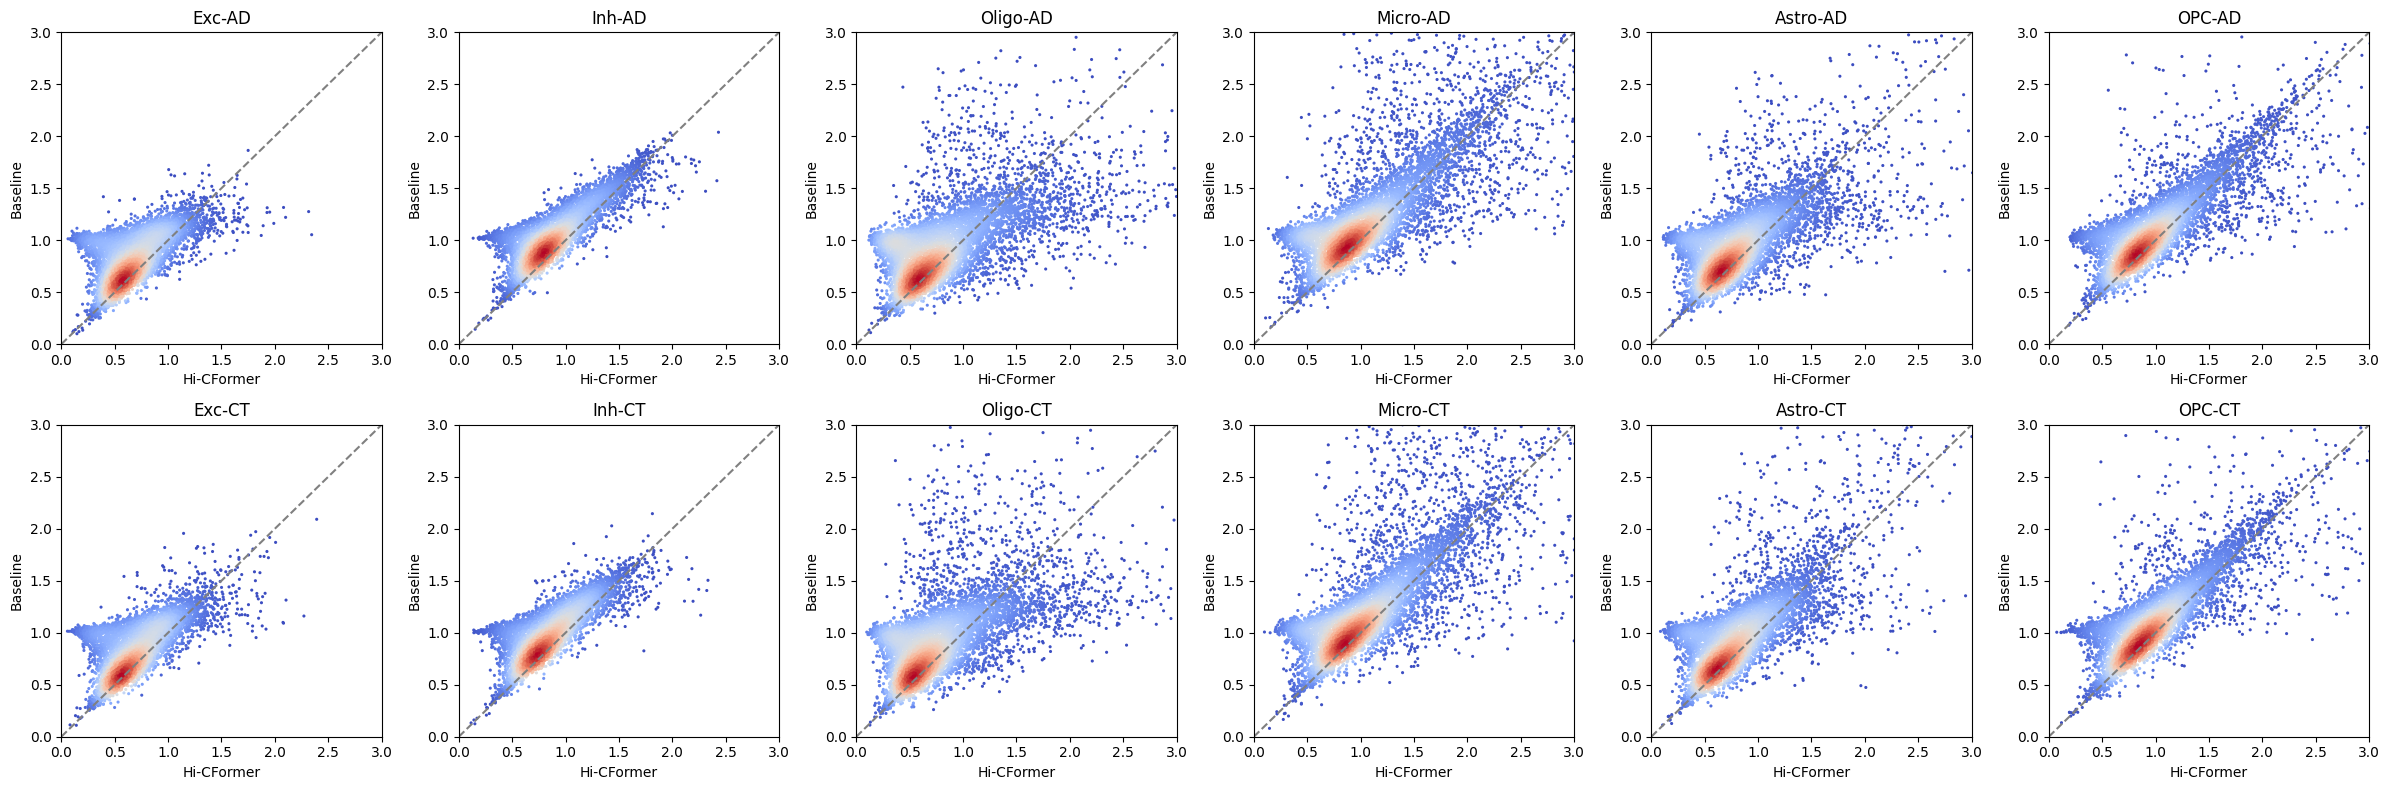

In [ ]:
# MSE
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(2,6, figsize=(24,8))
    for ax, (cell_type_name, cell_type_mask) in zip(axes.flat, cell_type_dict.items()):
        df = pd.DataFrame({
            'Hi-CFormer': calc_metric(p_h[cell_type_mask], e[cell_type_mask]),
            'Baseline': calc_metric(p_b[cell_type_mask], e[cell_type_mask]),
        })
        x = df.values
        x = x[~np.isnan(x).any(axis=1)]
        density = KernelDensity(bandwidth=.1).fit(x).score_samples(x)
        density = np.exp(density)
        df['density'] = density
        sns.scatterplot(
            ax=ax, data=df, x='Hi-CFormer', y='Baseline', edgecolor='none',
            s=5,
            palette='coolwarm', hue='density',
        )
        ax.axline((.5, .5), slope=1, linestyle='--', color='grey')
        #stat, pval = ttest_rel(*list(x.T), alternative='less')
        ax.set(title=f'{cell_type_name}')
        ax.set_xlim((0,3))
        ax.set_ylim((0,3))
        ax.get_legend().remove()
    fig.tight_layout()
    path2file = f'performance_comparison_scatter_majortype_{metric_str}.pdf'
    print(path2file)
    plt.savefig(path2file, dpi=600)
    plt.show()

# TFBS

In [6]:
path2base = Path("/home/xinyuelu/HiCFormer/data")
df_gene = pd.read_csv(path2base / 'gage-seq-AD-new' / 'genes.tsv', sep='\t')
df_tfbs = pd.read_csv(path2base / 'gage-seq-AD-new' / 'hit_r1000_dboth_thr0.csv.gz')
df_tfbs = df_tfbs[df_tfbs.gene_id.isin(df_gene.gene_id)]

In [7]:
df_gene.head(), df_gene.shape

(           gene_id      chrom      pos strand
 0  ENSG00000067606  hg38_chr1  2050411      +
 1  ENSG00000157933  hg38_chr1  2227388      +
 2  ENSG00000157916  hg38_chr1  2391775      +
 3  ENSG00000157911  hg38_chr1  2413797      -
 4  ENSG00000157881  hg38_chr1  2526597      -,
 (7598, 4))

In [8]:
df_tfbs.head(), df_tfbs.shape

(           gene_id   tf_name  hit
 0  ENSG00000000460  MA0003.1    1
 1  ENSG00000000460  MA0003.4    1
 2  ENSG00000000460  MA0014.3    1
 3  ENSG00000000460  MA0017.1    1
 4  ENSG00000000460  MA0036.1    2,
 (1168867, 3))

In [13]:
common_genes = list(set(df_gene.gene_id) & set(df_tfbs.gene_id))
all_genes = df_gene['gene_id'].unique()
df_tfbs = df_tfbs.set_index(['gene_id', 'tf_name']).hit.unstack().fillna(0).astype(int)
df_tfbs = df_tfbs.reindex(all_genes, fill_value=0)

In [14]:
df_tfbs

tf_name,MA0002.1,MA0003.1,MA0003.2,MA0003.3,MA0003.4,MA0007.2,MA0009.2,MA0014.2,MA0014.3,MA0017.1,...,MA1979.1,MA1980.1,MA1981.1,MA1982.1,MA1983.1,MA1984.1,MA1985.1,MA1986.1,MA1987.1,MA2003.1
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000067606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000157933,0,12,0,0,0,0,0,0,4,0,...,2,0,2,0,0,0,0,2,0,0
ENSG00000157916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000157911,0,0,6,0,4,0,0,0,2,0,...,0,2,10,4,0,0,2,4,4,0
ENSG00000157881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000075234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000075240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000054611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
seen_cell_type_idx = [2,3,4,5,6,7,8,9,11,13,14,15,16,18,19,20,22,23,24,25]
unseen_cell_type_idx = [0,1,10,12,17,21]
seen_gene_idx = np.arange(int(gene_num*0.8))
unseen_gene_idx = np.arange(int(gene_num*0.8), gene_num)

In [23]:
train_cell_type_num = 20
test_cell_type_num = 6

In [24]:
corr = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_all(prediction_all), fn_all(expression_all[:,:,80:-80])))])
corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_all(prediction_all_baseline), fn_all(expression_all[:,:,80:-80])))])
corr_diff = corr - corr_baseline

7598it [00:08, 939.18it/s]
7598it [00:07, 968.45it/s]


In [25]:
x = corr_diff
y = df_tfbs.values
df_test = pd.DataFrame([
    pearsonr(x, _)
    for _ in tqdm(y.T)
], index=df_tfbs.columns)

100%|██████████| 949/949 [00:01<00:00, 881.90it/s]


In [26]:
ttest_1samp(df_test.statistic, 0)

TtestResult(statistic=71.46805587128725, pvalue=0.0, df=948)

In [ ]:
def calc_metric(x, y):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    return np.array([pearsonr(*_)[0] for _ in zip(x, y)])
cell_type_indices, gene_indices = np.arange(0,26), np.arange(0,gene_num)
p_h = prediction_all[cell_type_indices][:, gene_indices]
p_b = prediction_all_baseline[cell_type_indices][:, gene_indices]
e = expression_all[cell_type_indices][:, gene_indices][..., 80:-80]
df = pd.DataFrame({
    'Hi-CFormer': calc_metric(p_h, e),
    'Baseline': calc_metric(p_b, e),
    'gene_id': df_meta_gene.gene_id[gene_indices].values,
}).set_index('gene_id')

In [ ]:
def calc_metric(x, y):
    c, g, l = x.shape
    x = x.transpose(1, 0, 2).reshape(g, c*l)
    y = y.transpose(1, 0, 2).reshape(g, c*l)
    return np.array([pearsonr(*_)[0] for _ in zip(x, y)])
cell_type_indices, gene_indices = np.array(seen_cell_type_idx), np.arange(0,gene_num)
p_h = prediction_all[cell_type_indices][:, gene_indices]
p_b = prediction_all_baseline[cell_type_indices][:, gene_indices]
e = expression_all[cell_type_indices][:, gene_indices][..., 80:-80]
df1 = pd.DataFrame({
    'Hi-CFormer': calc_metric(p_h, e),
    'Baseline': calc_metric(p_b, e),
    'gene_id': df_meta_gene.gene_id[gene_indices].values,
}).set_index('gene_id')

In [30]:
df['n_tfbs'] = df_tfbs.sum(1)
df_score = df
df_score
df1['n_tfbs'] = df_tfbs.sum(1)
df_score1 = df1

In [31]:
np.where(df_score['n_tfbs'] > 0)

(array([   1,    3,    5, ..., 7479, 7482, 7483]),)

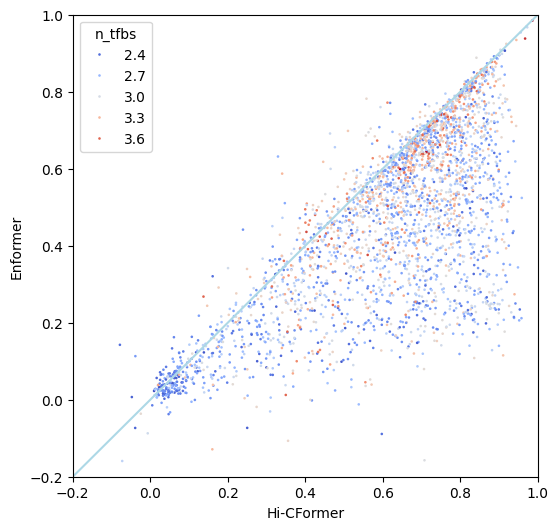

In [33]:
mask = np.where(df_score['n_tfbs'] > 0)
x, y = df_score['Hi-CFormer'].iloc[mask], df_score['Baseline'].iloc[mask]
fig, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(ax=ax, x=x, y=y, hue=np.log1p(df_tfbs.values[:, mask].mean(1)), edgecolor='none', palette='coolwarm')
sns.scatterplot(ax=ax, x=x, y=y, hue=np.log10(df_score['n_tfbs'].iloc[mask]), edgecolor='none', palette='coolwarm', s=3.5)
ax.axline((0, 0), slope=1, color='lightblue')
ax.set(xlabel='Hi-CFormer', ylabel='Enformer')
ax.set_xlim((-0.2,1))
ax.set_ylim((-0.2,1))
plt.show()
plt.close('all')